In [ ]:
!pip install gdown
!pip install tensorflow
!pip install --upgrade opencv-python

In [5]:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn.model_selection
import random
from tensorflow.keras import layers, Model

In [2]:
# To download the file
file_id = "1el92N8lBia2a5RFK0leeFQFRyhsEXaZx"
!gdown --id {file_id} -O rare_species.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx
From (redirected): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx&confirm=t&uuid=3a01d1d2-060d-48f9-940f-a3aaaaec5a29
To: /content/rare_species.zip
100% 4.26G/4.26G [01:03<00:00, 67.3MB/s]


In [3]:
# Verify file size
!ls -lh rare_species.zip

-rw-r--r-- 1 root root 4.0G Apr 11 12:01 rare_species.zip


In [6]:
# File extraction
extract_path = '/content/rare_species'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Created directory: {extract_path}")

print("Extracting zip ")
with zipfile.ZipFile('rare_species.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete")

Created directory: /content/rare_species
Extracting zip 
Extraction complete


In [7]:
# List fo contents for double-check
!ls -la {extract_path}

total 2924
drwxr-xr-x 204 root root   12288 Apr 22 16:30 .
drwxr-xr-x   1 root root    4096 Apr 22 16:29 ..
drwxr-xr-x   2 root root   12288 Apr 22 16:30 arthropoda_apidae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_attelabidae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_carabidae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_cerambycidae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_coenagrionidae
drwxr-xr-x   2 root root   24576 Apr 22 16:29 arthropoda_formicidae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_gomphidae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_lucanidae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_nymphalidae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_palinuridae
drwxr-xr-x   2 root root    4096 Apr 22 16:29 arthropoda_papilionidae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_pisauridae
drwxr-xr-x   2 root root    4096 Apr 22 16:30 arthropoda_platystictidae


In [8]:
# To load the csv file as metadata
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

if csv_files:
    metadata_path = os.path.join(extract_path, csv_files[0])
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with shape: {metadata.shape}")
    print(metadata.head())
else:
    print("No CSV file found.")

Found CSV files: ['metadata.csv']
Loaded metadata with shape: (11983, 7)
                        rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_tur

do we want this part?

In [ ]:
# Dropper les colonnes inutiles
#columns_to_keep = ['file_path', 'family', 'phylum']  # Garder seulement ce qui est nécessaire
#metadata = metadata[columns_to_keep]
#print('Colonnes restantes:', metadata.columns.tolist())

Colonnes restantes: ['file_path', 'family', 'phylum']


In [ ]:
#metadata.head()

,file_path,family,phylum
0,mollusca_unionidae/12853737_449393_eol-full-si...,unionidae,mollusca
1,chordata_geoemydidae/20969394_793083_eol-full-...,geoemydidae,chordata
2,chordata_cryptobranchidae/28895411_319982_eol-...,cryptobranchidae,chordata
3,chordata_turdidae/29658536_45510188_eol-full-s...,turdidae,chordata
4,chordata_indriidae/21252576_7250886_eol-full-s...,indriidae,chordata


In [9]:
# Set constants for data loading and preprocessing

DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
MIN_RESOLUTION = (100, 100)
CLASS_THRESHOLD = 10

# Define a seed for replications
SEED = 22
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Define the mean and the standard deviation expeted to our models (RGB patterns)
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# Data Preprocessing

In [10]:
def image_validator(path, min_resolution = MIN_RESOLUTION):
    """
    Checks whether an image exists and meets a minimum resolution.

    Requires:
        - path (str): Full path to the image file.
        - min_resolution (tuple): Minimum resolution as (width, height).

    Ensures:
        - Returns True if the image exists, is readable, and meets the resolution requirement.
        - Returns False otherwise (missing, unreadable, or low-resolution image).
    """
    try:
        with Image.open(path) as img:
            return img.size[0] >= min_resolution[0] and img.size[1] >= min_resolution[1]
    except:
        return False


def load_and_validate_data(data_path):
    """
    Loads metadata and filters out invalid or low-resolution image entries.

    Requires:
        - data_path (str): Path to the folder containing 'metadata.csv' and image files.

    Ensures:
        - Returns a cleaned DataFrame with only valid image entries.
        - Adds a 'full_path' column with the absolute path to each image.
    """
    metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
    metadata['full_path'] = metadata['file_path'].apply(lambda x: os.path.join(DATA_PATH, x))
    metadata['valid'] = metadata['full_path'].apply(lambda x: os.path.exists(x) and image_validator(x))
    return metadata[metadata['valid']].drop(columns=['valid'])

In [ ]:
def analyze_class_distribution(metadata):
    """
    Plots the distribution of image counts per family and prints rare classes.

    Requires:
        - metadata (pd.DataFrame): Must include a 'family' column with image labels.
        - CLASS_THRESHOLD (int): Global variable defining what counts as a 'rare' class.

    Ensures:
        - Displays a histogram showing how many images each family has.
        - Prints the number of families with fewer than CLASS_THRESHOLD images.
    """
    family_counts = metadata['family'].value_counts()

    plt.figure(figsize=(12, 6))
    sns.histplot(family_counts, bins=50)
    plt.title("Images per Family Distribution")
    plt.xlabel("Number of Images")
    plt.ylabel("Number of Families")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    rare_classes = family_counts[family_counts < CLASS_THRESHOLD]
    print(f"Rare families (<{CLASS_THRESHOLD} images): {len(rare_classes)}")

In [13]:
def create_datasets(metadata):
    """
    Prepares train and validation datasets from metadata, applying preprocessing and batching.

    Requires:
        - metadata (DataFrame): Cleaned metadata including 'full_path', 'family', and 'phylum' columns.

    Ensures:
        - Stratified train/val split on 'family'.
        - Normalized and resized image tensors.
        - Encoded phylum and family labels using StringLookup.
        - Returns train and validation datasets ready for training.

    Returns:
        - train_ds (tf.data.Dataset): Preprocessed and batched training set.
        - val_ds (tf.data.Dataset): Preprocessed and batched validation set.
        - family_lookup (StringLookup): Mapping for family class labels.
    """

    file_paths = metadata['full_path'].values
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    # Stratified split on family labels
    train_df, val_df = train_test_split(
        metadata,
        test_size=0.2,
        stratify=family_labels,
        random_state=SEED
    )

    # Lookup tables for string labels
    family_lookup = tf.keras.layers.StringLookup()
    family_lookup.adapt(family_labels)

    phylum_lookup = tf.keras.layers.StringLookup()
    phylum_lookup.adapt(phylum_labels)

    # Image preprocessing function
    def preprocess(file_path, family, phylum):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = tf.ensure_shape(img, [224, 224, 3])
        phylum_idx = phylum_lookup(phylum)
        family_idx = family_lookup(family)
        return (img, phylum_idx), family_idx

    # Optional data augmentation
    def augment(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32))
        return (image, phylum), label

    # Final dataset creator
    def make_dataset(df):
        return tf.data.Dataset.from_tensor_slices(dict(df)) \
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
            .batch(BATCH_SIZE) \
            .prefetch(tf.data.AUTOTUNE)

    return make_dataset(train_df), make_dataset(val_df), family_lookup


# First Approach

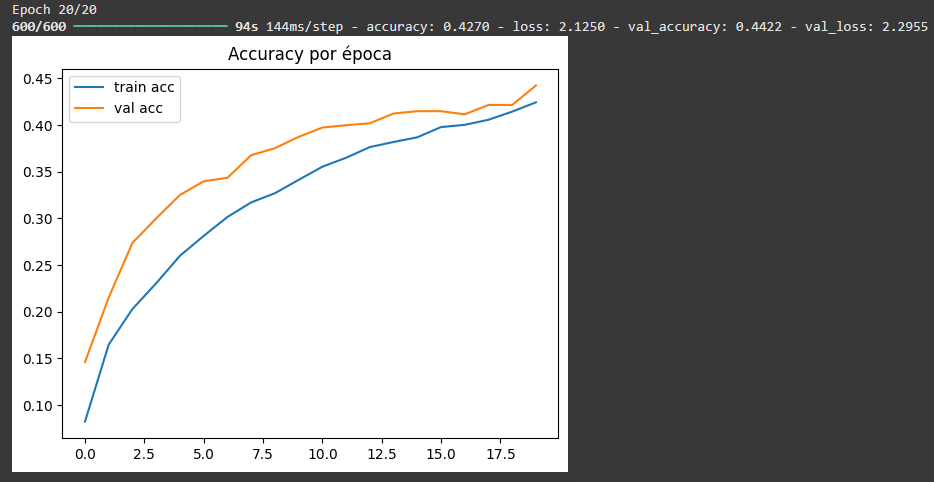

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 100s 150ms/step - accuracy: 0.0487 - loss: 5.0338 - val_accuracy: 0.1460 - val_loss: 3.9387
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 145ms/step - accuracy: 0.1534 - loss: 3.8872 - val_accuracy: 0.2153 - val_loss: 3.3445
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 145ms/step - accuracy: 0.1967 - loss: 3.4437 - val_accuracy: 0.2737 - val_loss: 3.0696
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 145ms/step - accuracy: 0.2238 - loss: 3.2109 - val_accuracy: 0.3000 - val_loss: 2.9218
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.2546 - loss: 3.0385 - val_accuracy: 0.3250 - val_loss: 2.7611
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 145ms/step - accuracy: 0.2813 - loss: 2.9027 - val_accuracy: 0.3396 - val_loss: 2.6745
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.3018 - loss: 2.7785 - val_accuracy: 0.3433 - val_loss: 2.6191
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.3209 - loss: 

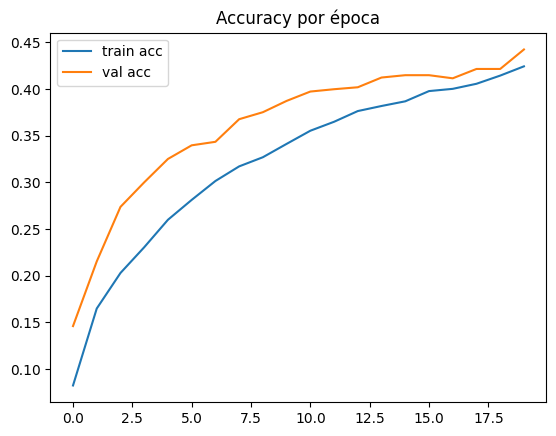

In [ ]:
# Improved Preprocessing + Model Analysis (versão com base no teu setup)

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image

# ============================
# CONFIGURAÇÕES GERAIS
# ============================
DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# ============================
# 1. FILTRAR IMAGENS COM QUALIDADE BAIXA
# ============================
def is_valid_image(path, min_resolution=(100, 100)):
    try:
        img = Image.open(path)
        return img.size[0] >= min_resolution[0] and img.size[1] >= min_resolution[1]
    except:
        return False

def load_and_clean_metadata(data_path):
    metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
    metadata['full_path'] = metadata['file_path'].apply(lambda x: os.path.join(data_path, x))
    metadata['valid'] = metadata['full_path'].apply(lambda x: os.path.exists(x) and is_valid_image(x))
    return metadata[metadata['valid'] == True]

# ============================
# 2. ANALISAR FAMÍLIAS
# ============================
def analyze_classes(metadata):
    family_counts = metadata['family'].value_counts()
    plt.figure(figsize=(14, 6))
    sns.histplot(family_counts, bins=50, kde=False)
    plt.title("Distribuição do número de imagens por família")
    plt.xlabel("Número de imagens")
    plt.ylabel("Número de famílias")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Famílias com menos de 10 imagens:")
    print(family_counts[family_counts < 10])

# ============================
# 3. PREPARAÇÃO DO DATASET
# ============================
def prepare_datasets_cleaned(metadata):
    file_paths = metadata['full_path'].values
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    train_paths, val_paths, train_families, val_families, train_phyla, val_phyla = train_test_split(
        file_paths, family_labels, phylum_labels,
        test_size=0.2, stratify=family_labels, random_state=SEED
    )

    family_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    family_lookup.adapt(train_families)
    phylum_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    phylum_lookup.adapt(train_phyla)

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_families, train_phyla))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_families, val_phyla))

    def preprocess(file_path, family, phylum):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = tf.ensure_shape(img, [224, 224, 3])
        phylum_idx = phylum_lookup(phylum)
        family_idx = family_lookup(family)
        return (img, phylum_idx), family_idx

    def augment(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32))
        return (image, phylum), label

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, family_lookup, phylum_lookup, train_families, val_families

# ============================
# 4. EXECUÇÃO DO PROCESSAMENTO
# ============================
metadata = load_and_clean_metadata(DATA_PATH)
analyze_classes(metadata)
train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = prepare_datasets_cleaned(metadata)
NUM_FAMILIES = len(family_lookup.get_vocabulary())
NUM_PHYLA = len(phylum_lookup.get_vocabulary())
print("✅ Dados carregados e prontos")

# ============================
# 5. DEFINIÇÃO DE MODELOS BASE
# ============================
def build_pretrained_model(base_model, name, num_phyla, num_families):
    base_model.trainable = False
    image_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = base_model(image_input, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    x = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name=name)

model_vgg16 = build_pretrained_model(
    tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "VGG16_Model", NUM_PHYLA, NUM_FAMILIES)

model_resnet = build_pretrained_model(
    tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "ResNet50_Model", NUM_PHYLA, NUM_FAMILIES)

model_efficient = build_pretrained_model(
    tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "EfficientNetB0_Model", NUM_PHYLA, NUM_FAMILIES)

# ============================
# 6. MODELO PERSONALIZADO CNN
# ============================
def build_custom_cnn(num_phyla, num_families):
    img_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, phylum_input], outputs=output, name="CustomCNN")

# ============================
# 7. TREINAMENTO DO MODELO
# ============================
model = model_vgg16  # Ou outro modelo que deseje testar
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ============================
# 8. VISUALIZAÇÃO
# ============================
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

# Second Approach


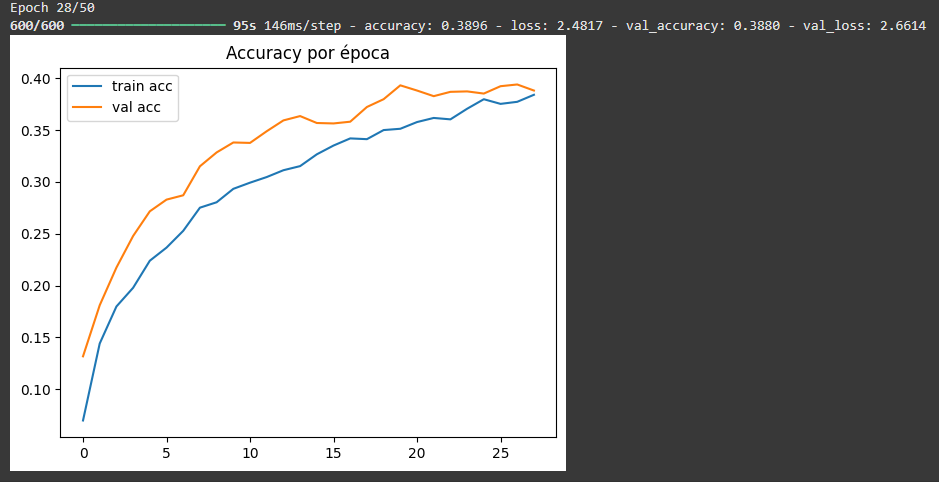

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 101s 151ms/step - accuracy: 0.0418 - loss: 5.0850 - val_accuracy: 0.1318 - val_loss: 4.1056
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 96s 147ms/step - accuracy: 0.1384 - loss: 4.0774 - val_accuracy: 0.1811 - val_loss: 3.5711
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 145ms/step - accuracy: 0.1779 - loss: 3.6931 - val_accuracy: 0.2174 - val_loss: 3.3587
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 147ms/step - accuracy: 0.1925 - loss: 3.5127 - val_accuracy: 0.2478 - val_loss: 3.1929
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.2226 - loss: 3.3449 - val_accuracy: 0.2716 - val_loss: 3.0732
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.2395 - loss: 3.2326 - val_accuracy: 0.2829 - val_loss: 2.9824
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 147ms/step - accuracy: 0.2526 - loss: 3.1318 - val_accuracy: 0.2870 - val_loss: 2.9268
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.2788 - loss: 

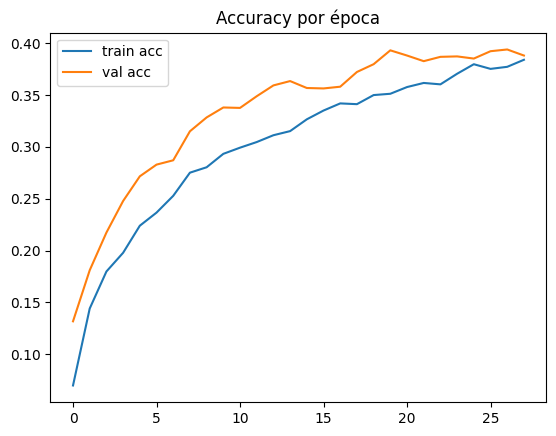

In [ ]:
# Improved Preprocessing + Model Analysis (versão com base no teu setup)

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image

# ============================
# CONFIGURAÇÕES GERAIS
# ============================
DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# ============================
# 1. FILTRAR IMAGENS COM QUALIDADE BAIXA
# ============================
def is_valid_image(path, min_resolution=(100, 100)):
    try:
        img = Image.open(path)
        return img.size[0] >= min_resolution[0] and img.size[1] >= min_resolution[1]
    except:
        return False

def load_and_clean_metadata(data_path):
    metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
    metadata['full_path'] = metadata['file_path'].apply(lambda x: os.path.join(data_path, x))
    metadata['valid'] = metadata['full_path'].apply(lambda x: os.path.exists(x) and is_valid_image(x))
    return metadata[metadata['valid'] == True]

# ============================
# 2. ANALISAR FAMÍLIAS
# ============================
def analyze_classes(metadata):
    family_counts = metadata['family'].value_counts()
    plt.figure(figsize=(14, 6))
    sns.histplot(family_counts, bins=50, kde=False)
    plt.title("Distribuição do número de imagens por família")
    plt.xlabel("Número de imagens")
    plt.ylabel("Número de famílias")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Famílias com menos de 10 imagens:")
    print(family_counts[family_counts < 10])

# ============================
# 3. PREPARAÇÃO DO DATASET
# ============================
def prepare_datasets_cleaned(metadata):
    file_paths = metadata['full_path'].values
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    train_paths, val_paths, train_families, val_families, train_phyla, val_phyla = train_test_split(
        file_paths, family_labels, phylum_labels,
        test_size=0.2, stratify=family_labels, random_state=SEED
    )

    family_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    family_lookup.adapt(train_families)
    phylum_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    phylum_lookup.adapt(train_phyla)

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_families, train_phyla))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_families, val_phyla))

    def preprocess(file_path, family, phylum):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = tf.ensure_shape(img, [224, 224, 3])
        phylum_idx = phylum_lookup(phylum)
        family_idx = family_lookup(family)
        return (img, phylum_idx), family_idx

    def augment(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32))
        return (image, phylum), label

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, family_lookup, phylum_lookup, train_families, val_families

# ============================
# 4. EXECUÇÃO DO PROCESSAMENTO
# ============================
metadata = load_and_clean_metadata(DATA_PATH)
analyze_classes(metadata)
train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = prepare_datasets_cleaned(metadata)
NUM_FAMILIES = len(family_lookup.get_vocabulary())
NUM_PHYLA = len(phylum_lookup.get_vocabulary())
print("✅ Dados carregados e prontos")

# ============================
# 5. DEFINIÇÃO DE MODELOS BASE
# ============================
def build_pretrained_model(base_model, name, num_phyla, num_families):
    base_model.trainable = False
    image_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = base_model(image_input, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    x = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name=name)

model_vgg16 = build_pretrained_model(
    tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "VGG16_Model", NUM_PHYLA, NUM_FAMILIES)

model_resnet = build_pretrained_model(
    tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "ResNet50_Model", NUM_PHYLA, NUM_FAMILIES)

model_efficient = build_pretrained_model(
    tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "EfficientNetB0_Model", NUM_PHYLA, NUM_FAMILIES)

# ============================
# 6. MODELO PERSONALIZADO CNN
# ============================
def build_custom_cnn(num_phyla, num_families):
    img_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, phylum_input], outputs=output, name="CustomCNN")

# ============================
# 7. TREINAMENTO DO MODELO
# ============================
model = model_vgg16  # Ou outro modelo que deseje testar
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ============================
# 8. VISUALIZAÇÃO
# ============================
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()


# Third Approach

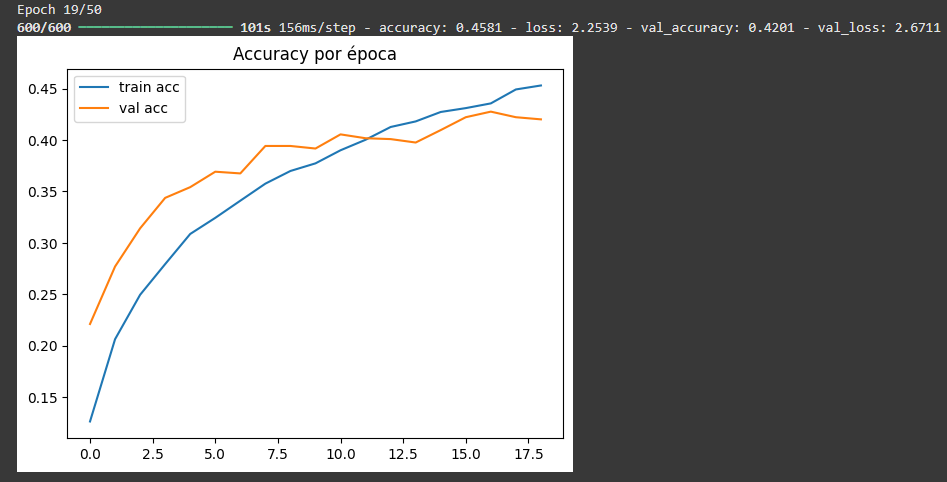

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


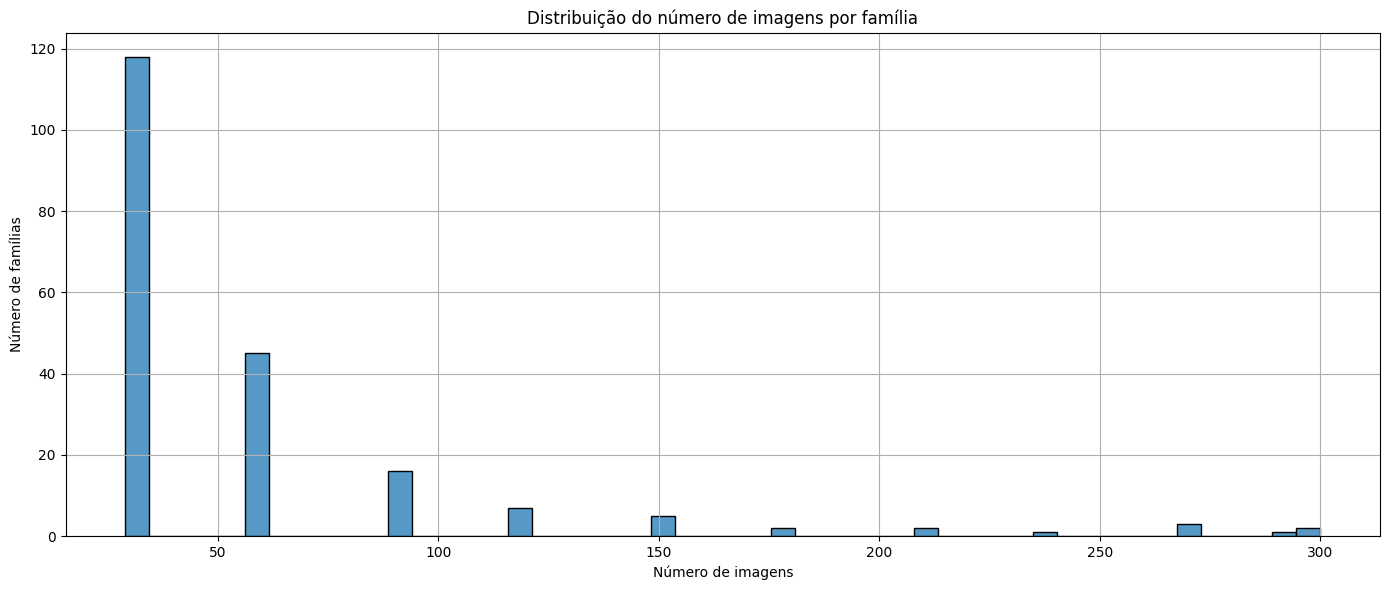

Famílias com menos de 10 imagens:
Series([], Name: count, dtype: int64)
Dados carregados e prontos
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 125s 174ms/step - accuracy: 0.0899 - loss: 4.8723 - val_accuracy: 0.2211 - val_loss: 3.5224
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 100s 154ms/step - accuracy: 0.1978 - loss: 3.6399 - val_accuracy: 0.2770 - val_loss: 3.1572
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 100s 153ms/step - accuracy: 0.2475 - loss: 3.3156 - val_accuracy: 0.3141 - val_loss: 2.9370
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 100s 153ms/step - accuracy: 0.2755 - loss: 3.0965 - val_accuracy: 0.3438 - val_loss: 2.8103
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 100s 154ms/step - accuracy: 0.3060 - loss: 2.9756 - val_accuracy: 0.3542 - val_loss: 2.7974
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 100s 154ms/step - accuracy: 0.3257 - loss: 2.8570 - val_accuracy: 0.3692 - val_loss: 2.6931
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 100s 153ms/step - 

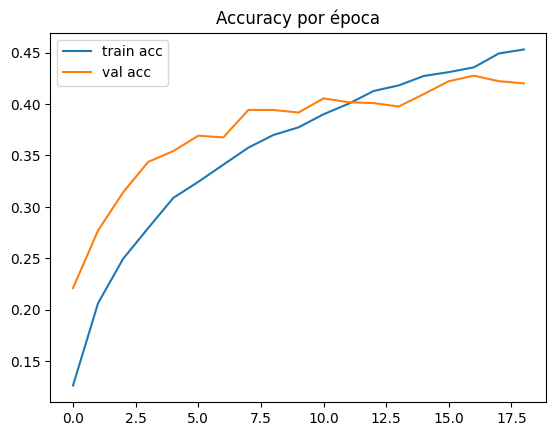

In [ ]:
# Improved Preprocessing + Model Analysis (versão final para testes)

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image

# ============================
# CONFIGURAÇÕES GERAIS
# ============================
DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# ============================
# 1. FILTRAR IMAGENS COM QUALIDADE BAIXA
# ============================
def is_valid_image(path, min_resolution=(100, 100)):
    try:
        img = Image.open(path)
        return img.size[0] >= min_resolution[0] and img.size[1] >= min_resolution[1]
    except:
        return False

def load_and_clean_metadata(data_path):
    metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
    metadata['full_path'] = metadata['file_path'].apply(lambda x: os.path.join(data_path, x))
    metadata['valid'] = metadata['full_path'].apply(lambda x: os.path.exists(x) and is_valid_image(x))
    return metadata[metadata['valid'] == True]

# ============================
# 2. ANÁLISE DAS CLASSES
# ============================
def analyze_classes(metadata):
    family_counts = metadata['family'].value_counts()
    plt.figure(figsize=(14, 6))
    sns.histplot(family_counts, bins=50, kde=False)
    plt.title("Distribuição do número de imagens por família")
    plt.xlabel("Número de imagens")
    plt.ylabel("Número de famílias")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Famílias com menos de 10 imagens:")
    print(family_counts[family_counts < 10])

# ============================
# 3. PREPARAÇÃO DO DATASET
# ============================
def prepare_datasets_cleaned(metadata):
    file_paths = metadata['full_path'].values
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    train_paths, val_paths, train_families, val_families, train_phyla, val_phyla = train_test_split(
        file_paths, family_labels, phylum_labels,
        test_size=0.2, stratify=family_labels, random_state=SEED
    )

    family_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    family_lookup.adapt(train_families)
    phylum_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    phylum_lookup.adapt(train_phyla)

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_families, train_phyla))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_families, val_phyla))

    def preprocess(file_path, family, phylum):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = tf.ensure_shape(img, [224, 224, 3])
        return (img, phylum_lookup(phylum)), family_lookup(family)

    def augment(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_hue(image, 0.05)
        image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32))
        return (image, phylum), label

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, family_lookup, phylum_lookup, train_families, val_families

# ============================
# 4. EXECUTAR O FLUXO DE PREPARAÇÃO
# ============================
metadata = load_and_clean_metadata(DATA_PATH)
analyze_classes(metadata)
train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = prepare_datasets_cleaned(metadata)
NUM_FAMILIES = len(family_lookup.get_vocabulary())
NUM_PHYLA = len(phylum_lookup.get_vocabulary())
print("✅ Dados carregados e prontos")

# ============================
# 5. CONSTRUÇÃO DO MODELO V2
# ============================
def build_pretrained_model_v2(base_model, name, num_phyla, num_families):
    base_model.trainable = False

    image_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = base_model(image_input, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)
    phylum_embed = tf.keras.layers.Dense(64, activation='relu')(phylum_embed)

    x = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name=name)

# ============================
# 6. INSTANCIAR E TREINAR MODELO
# ============================
base = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_vgg16 = build_pretrained_model_v2(base, "VGG16_Model", NUM_PHYLA, NUM_FAMILIES)

model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model_vgg16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ============================
# 7. VISUALIZAR RESULTADOS
# ============================
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()